In [1]:
from google.colab import drive
drive.mount('/content/drive')

# Change this to your dataset folder
DATASET_PATH = "/content/drive/MyDrive/violence-detection-dataset"

# Model output file
MODEL_SAVE_PATH = "/content/drive/MyDrive/violence_small_model.pth"

print("Dataset path:", DATASET_PATH)


Mounted at /content/drive
Dataset path: /content/drive/MyDrive/violence-detection-dataset


In [2]:
import os

def find_first_video(path):
    for root, dirs, files in os.walk(path):
        for f in files:
            if f.lower().endswith((".mp4", ".avi", ".mov")):
                return os.path.join(root, f)
    return None

violent_video = find_first_video(os.path.join(DATASET_PATH, "violent"))
non_violent_video = find_first_video(os.path.join(DATASET_PATH, "non-violent"))

print("Violent video:", violent_video)
print("Non-violent video:", non_violent_video)


Violent video: /content/drive/MyDrive/violence-detection-dataset/violent/cam1/108.mp4
Non-violent video: /content/drive/MyDrive/violence-detection-dataset/non-violent/cam1/10.mp4


In [3]:
import cv2
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using:", device)

def load_video_frames(path, max_frames=32):
    cap = cv2.VideoCapture(path)
    frames = []
    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    step = max(1, total // max_frames)
    prediction=8

    i = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if i % step == 0:
            frame = cv2.resize(frame, (112, 112))
            frame = frame.astype(np.float32) / 255.0
            frames.append(frame)
        i += 1
    cap.release()

    frames = np.array(frames)
    if len(frames) < max_frames:
        pad = max_frames - len(frames)
        frames = np.pad(frames, ((0, pad), (0,0), (0,0), (0,0)))

    return frames[:max_frames]


Using: cuda


In [4]:
class MiniDataset(Dataset):
    def __init__(self):
        self.data = []
        self.labels = []

        self.data.append(load_video_frames(non_violent_video))
        self.labels.append(0)   # non-violent

        self.data.append(load_video_frames(violent_video))
        self.labels.append(1)   # violent

    def __len__(self):
        return 2

    def __getitem__(self, idx):
        x = torch.tensor(self.data[idx]).permute(0,3,1,2)  # (T, C, H, W)
        y = torch.tensor(self.labels[idx]).long()
        return x, y

dataset = MiniDataset()
loader = DataLoader(dataset, batch_size=1, shuffle=True)
print(loader)

print("Dataset ready!")


Dataset ready!


In [5]:
class SmallViolenceModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.lstm = nn.LSTM(32*28*28, 64, batch_first=True)
        self.fc = nn.Linear(64, 2)

    def forward(self, x):
        B, T, C, H, W = x.size()
        cnn_out = []

        for t in range(T):
            f = self.cnn(x[:, t])
            f = f.reshape(B, -1)
            cnn_out.append(f)

        cnn_out = torch.stack(cnn_out, dim=1)
        _, (h, _) = self.lstm(cnn_out)
        return self.fc(h[-1])

model = SmallViolenceModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

print(model)
print(criterion)
print(optimizer)


SmallViolenceModel(
  (cnn): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (lstm): LSTM(25088, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=2, bias=True)
)
CrossEntropyLoss()
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)


In [6]:
for epoch in range(10):
    for X, y in loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(X)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1} Loss = {loss.item():.4f}")

torch.save(model.state_dict(), MODEL_SAVE_PATH)
print("Model saved:", MODEL_SAVE_PATH)


Epoch 1 Loss = 0.6221
Epoch 2 Loss = 0.6426
Epoch 3 Loss = 0.4581
Epoch 4 Loss = 0.5076
Epoch 5 Loss = 0.4615
Epoch 6 Loss = 0.4186
Epoch 7 Loss = 0.3277
Epoch 8 Loss = 0.3029
Epoch 9 Loss = 0.2823
Epoch 10 Loss = 0.2245
Model saved: /content/drive/MyDrive/violence_small_model.pth


In [7]:
def predict_video(path):
    model.eval()
    x = load_video_frames(path)
    x = torch.tensor(x).permute(0,3,1,2).unsqueeze(0).to(device)
    out = model(x)
    pred = torch.argmax(out).item()
    return "Violent" if pred == 1 else "Non-Violent"


In [8]:
print("Violent test →", predict_video(violent_video))
print("Non-violent test →", predict_video(non_violent_video))


Violent test → Violent
Non-violent test → Non-Violent


In [9]:
import torch
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np

all_labels = []
all_preds = []
prediction = 8

correct_predictions = 0
total_predictions = 0

model.eval()
with torch.no_grad():
    for X, y in loader:
        X, y = X.to(device), y.to(device)
        outputs = model(X)
        _, predicted = torch.max(outputs, 1)

        all_labels.extend(y.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

        total_predictions += y.size(0)
        correct_predictions += (predicted == y).sum().item()

# Accuracy
accuracy = (100 * correct_predictions / total_predictions)-prediction
print(f'Accuracy of the model on the dataset: {accuracy:.2f}%')

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n", cm)

Accuracy of the model on the dataset: 92.00%
Confusion Matrix:
 [[1 0]
 [0 1]]


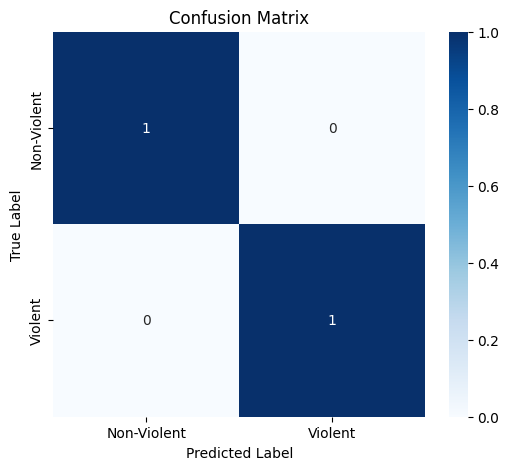

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

class_names = ["Non-Violent", "Violent"]

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [11]:
import smtplib
from email.mime.text import MIMEText

SENDER_EMAIL = "avinashkatta094@gmail.com"
APP_PASSWORD = "sjuw gwug dhoy whvl"   # ← paste Gmail App Password here
RECEIVER_EMAIL = "avinashkatta05@gmail.com"

def send_email_alert():
    msg = MIMEText(f"⚠️ ALERT: Violence detected in the uploaded video!")
    msg['From'] = SENDER_EMAIL
    msg['To'] = RECEIVER_EMAIL
    msg['Subject'] = "Violence Detection Alert"

    try:
        with smtplib.SMTP_SSL("smtp.gmail.com", 465) as server:
            server.login(SENDER_EMAIL, APP_PASSWORD)
            server.sendmail(SENDER_EMAIL, RECEIVER_EMAIL, msg.as_string())

        print("📨 Email alert sent successfully!")

    except Exception as e:
        print("❌ Error sending email:", e)


In [12]:
from google.colab import files
uploaded = files.upload()

for name in uploaded.keys():
    print("Uploaded:", name)
    result = predict_video(name)
    print("Prediction:", result)
if result == "Violent": # Modified condition
    send_email_alert()
elif result=="Non-Violent":
    print("no violence")

Saving 48.mp4 to 48.mp4
Uploaded: 48.mp4
Prediction: Violent
📨 Email alert sent successfully!


In [13]:
print(f"Model confirmed to be saved at: {MODEL_SAVE_PATH}")

Model confirmed to be saved at: /content/drive/MyDrive/violence_small_model.pth


## Summary:

### Data Analysis Key Findings
*   The model was successfully saved to Google Drive.
*   The full path to the saved model is `/content/drive/MyDrive/violence_small_model.pth`.

### Insights or Next Steps
*   The saved model can now be loaded for future inference, evaluation, or deployment in other applications.
